# Atlas Segmentation - Medical Image Segmentation and Applications (MISA)

This notebook contains all necessary code to segment brain tissues (WM, GM, CSF) using probabilistic atas based approach.

**TODO:**
1. Markov Random Field in `segment_using_tissue_models_and_atlas` where probabilities are multiplied to form a posterior.
2. In `segment_using_tissue_models_and_atlas`, handle bins>100 to be CSF probabilities.

## 1. Imports

In [1]:
import os
import subprocess
from glob import glob
import math
from tqdm import tqdm
import pprint
import pandas as pd
import nibabel as nib
import numpy as np
from scipy.stats import pearsonr
from skimage import exposure
import matplotlib.pyplot as plt

pp = pprint.PrettyPrinter(indent=4)

## 2. Helper functions

In [7]:
def excute_cmd(command):
    # excute the command
    result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, shell=True)

    # Check the return code to see if the command was successful
    if result.returncode == 0:
        # print("Command executed successfully.")
        # print("Output:")
        return result.stdout
    else:
        print(f"Command failed with an error: {command}")
        print(result.stderr)
        return result.stderr

def create_directory_if_not_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
def replace_text_in_file(file_path, search_text, replacement_text):
    '''Function used to read a txt file, search for a given text, modify it, and save it in the same file.
    '''
    try:
        # Read the file
        with open(file_path, 'r') as file:
            content = file.read()

        # Replace the search_text with replacement_text
        modified_content = content.replace(search_text, replacement_text)

        # Write the modified content back to the file
        with open(file_path, 'w') as file:
            file.write(modified_content)

        # print(f"Text replaced in {file_path} and saved.")
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    # except Exception as e:
    #     print(f"An error occurred: {e}")

def min_max_normalization(self, image, max_value):
    # Ensure the image is a NumPy array for efficient calculations
    image = np.array(image)
    
    # Calculate the minimum and maximum pixel values
    min_value = np.min(image)
    max_actual = np.max(image)
    
    # Perform min-max normalization
    normalized_image = (image - min_value) / (max_actual - min_value) * max_value
    
    return normalized_image

def pprint_objects(*arg):
    '''Prints large and indented objects clearly.'''
    pp.pprint(arg)

def skull_stripping(image, label):
    '''
    Labels from the atlas to validate:
     - bg = 0
     - csf = 1
     - wm = 2
     - gm = 3
    '''

    # convert the labels to binary form, all tissues to 1, else is 0
    labels_binary   = np.where(label == 0, 0, 1)

    # multiply the image to get only the tissues
    return np.multiply(image, labels_binary)

def segment_using_tissue_models(image, tissue_map_csv):
    '''
    Task (1.1) Tissue models: segmentation using just intensity information.

    Args:
        - image (np.array): a normalized [0, 255] test intensity image to segment.
        - tissue_map_csv (csv): a csf file name that contains the tissue maps probabilities 
    '''
    # read the tissues moodels
    tissue_map_df = pd.read_csv(tissue_map_csv, header=None)
    tissue_map_array = tissue_map_df.values

    # obtain the argmax to know to which cluster each row (histogram pin - 0:255) falls into
    tissue_map_array_argmax = np.argmax(tissue_map_array, axis=1) + 1
    
    # convert bg pixels above 100 to wm
    # the threshold of 100 is observed from the probabilistic tissue map
    bg_mask = np.arange(len(tissue_map_array_argmax)) > 100
    tissue_map_array_argmax[bg_mask] = 2

    # create a black image as a template for the segmentation to fill
    segmentation_result =  np.zeros_like(image)

    # loop through the argmax values of the tissue map
    # index represent the pixel value we want to map to its corrosponding segmentation result of the argmax
    # the value is the new label of that pixel
    for index, value in enumerate(tissue_map_array_argmax):
        # we add a condition to select the pixels that are equal to the index, and not the background as we want to preserve the background
        condition = np.logical_and(image == index, image != 0)
        
        # we update the zeros template with the label value that we obtained from argmax 
        segmentation_result[condition] = value

    return segmentation_result

def segment_using_tissue_atlas(image, *atlases):
    '''
    Task (1.2) Label propagation: segmentation using just position information using atlases

    Args:
        - image (np.array): a normalized [0, 255] and skull stripped intensity image to segment.
        - atlases (np.arrays): atlases for CSF, WM, and GM as in order.
    '''

    # get the atlases
    atlas_csf = atlases[0]
    atlas_wm  = atlases[1]
    atlas_gm  = atlases[2]

    # flatten the input image
    registered_volume_test = image.flatten()

    # concatenate the flatenned atlases to form a NxK shaped array of arrays
    concatenated_atlas = np.column_stack((atlas_csf.flatten(), atlas_wm.flatten(), atlas_gm.flatten()))

    # get the argmax for each row to find which cluster does each sample refers to
    atlases_argmax = np.argmax(concatenated_atlas, axis=1) + 1

    # Create a mask to identify non-zero pixels
    non_zero_mask = registered_volume_test != 0

    # Replace non-zero pixels with their equivalent values from atlas argmax
    segmented_image = np.where(non_zero_mask, atlases_argmax, 0)

    # Reshape the segmented image to its original shape if needed
    segmented_image = segmented_image.reshape(image.shape)

    return segmented_image

def segment_using_tissue_models_and_atlas(image, tissue_map_csv, *atlases):
    '''(1.3) Tissue models & label propagation: multiplying both results: segmentation using intensity & position information

    Args:
        - image (np.array): a normalized [0, 255] and skull stripped intensity image to segment.
        - tissue_map_csv (csv): a csf file name that contains the tissue maps probabilities 
        - atlases (np.arrays): atlases for CSF, WM, and GM as in order.
    '''
    # read the tissues moodels
    tissue_map_df = pd.read_csv(tissue_map_csv, header=None)
    tissue_map_array = tissue_map_df.values

    # get the atlases
    atlas_csf = atlases[0]
    atlas_wm  = atlases[1]
    atlas_gm  = atlases[2]

    # concatenate the flatenned atlases to form a NxK shaped array of arrays
    concatenated_atlas = np.column_stack((atlas_csf.flatten(), atlas_wm.flatten(), atlas_gm.flatten())) # (18808832, 3)

    # Perform Bayesian segmentation
    registered_volume_test = image.flatten()

    # using registered_volume_test as an index to extract specific rows from tissue_map_array
    tissue_map_array = tissue_map_array[registered_volume_test, :]

    # multiply the probabilities
    posteriors = tissue_map_array * concatenated_atlas

    # ger the argmax for each sample to know for which cluster does it belongs, +1 to avoid 0 value
    posteriors_argmax = np.argmax(posteriors, axis=1) + 1

    # Create a mask to identify non-zero pixels
    non_zero_mask = registered_volume_test != 0

    # Replace non-zero pixels with their equivalent values from atlas argmax
    segmented_image = np.where(non_zero_mask, posteriors_argmax, 0)

    # Reshape the segmented image to its original shape if needed
    segmented_image = segmented_image.reshape(image.shape)

    return segmented_image

# Perform registration and label propagation
def register_elastix(fixed_path, 
                     moving_path, 
                     reg_params, 
                     create_dir_callback, 
                     excute_cmd_callback):

    # Get the names of the fixed and moving images for the output directory, names without the file extensions
    reg_fixed_name  = fixed_path.replace("\\", "/").split("/")[-1].split(".")[0] # \\
    reg_moving_name = moving_path.replace("\\", "/").split("/")[-1].split(".")[0]

    # create output dir
    output_dir = f'output/images/output_{reg_fixed_name}/{reg_moving_name}'
    create_dir_callback(output_dir)

    # create elastix command line
    command_line = f'elastix -f "{fixed_path}" -m "{moving_path}" {reg_params} -out "{output_dir}"'

    # call elastix command
    excute_cmd_callback(command_line)

def label_propagation_transformix(
    fixed_path, 
    moving_path, 
    input_label, 
    transform_path, 
    replace_text_in_file_callback, 
    create_dir_callback, 
    excute_cmd_callback):
    
    replace_text_in_file_callback(
        transform_path, 
        search_text = '(FinalBSplineInterpolationOrder 3)', 
        replacement_text =  '(FinalBSplineInterpolationOrder 0)')

    # Get the names of the fixed and moving images for the output directory, names without the file extensions
    reg_fixed_name  = fixed_path.replace("\\", "/").split("/")[-1].split(".")[0] # \\
    reg_moving_name = moving_path.replace("\\", "/").split("/")[-1].split(".")[0]
        
    # create an output directory for the labels
    output_dir = f'output/labels/output_{reg_fixed_name}/{reg_moving_name}' # rem _float64

    # creates the output directory
    create_dir_callback(output_dir)
    
    # create transformix command line
    command_line = f'transformix -in "{input_label}" -tp "{transform_path}"  -out "{output_dir}"'
    
    # run transformix on all combinations
    excute_cmd_callback(command_line)

In [8]:
class NiftiManager:
    def __init__(self) -> None:
        pass

    def load_nifti(self, file_path):
        '''Loads the NIfTI image and access the image data as a Numpy array.'''
        nii_image = nib.load(file_path)
        data_array = nii_image.get_fdata()

        return data_array, nii_image

    def show_nifti(self, file_data, title, slice=25):
        '''Displays a single slice from the nifti volume (change the slice index as needed).'''
        plt.imshow(file_data[:, :, slice], cmap='gray')
        plt.title(title)
        plt.colorbar()
        plt.show()

    def show_label_seg_nifti(self, label, seg, subject_id, slice=25):
        '''Displays both segmentation and ground truth labels as passed to the function.'''
        plt.figure(figsize=(20, 7))
        
        plt.subplot(1, 2, 1)
        plt.imshow(label[:, :, slice], cmap='gray') 
        plt.title(f'Label Image (Subject ID={subject_id})')
        plt.colorbar()

        plt.subplot(1, 2, 2)
        plt.imshow(seg[:, :, slice], cmap='gray') 
        plt.title(f'Segmentation Image (Subject ID={subject_id})')
        plt.colorbar()
        plt.show()

    def show_mean_volumes(self, mean_csf, mean_wm, mean_gm, slices=[128], export=False, filename=None):
        '''Displays the mean volumes for CSF, WM, and GM for a list of slices.'''
        num_slices = len(slices)
        
        plt.figure(figsize=(20, 7 * num_slices))

        for i, slice in enumerate(slices):
            plt.subplot(num_slices, 3, i * 3 + 1)
            plt.imshow(mean_csf[:, :, slice], cmap='gray')
            plt.title(f'Average CSF Volume - Slice {slice}')
            # plt.colorbar()
            plt.axis('off')

            plt.subplot(num_slices, 3, i * 3 + 2)
            plt.imshow(mean_wm[:, :, slice], cmap='gray')
            plt.title(f'Average WM Volume - Slice {slice}')
            # plt.colorbar()
            plt.axis('off')

            plt.subplot(num_slices, 3, i * 3 + 3)
            plt.imshow(mean_gm[:, :, slice], cmap='gray')
            plt.title(f'Average GM Volume - Slice {slice}')
            # plt.colorbar()
            plt.axis('off')

        if export and filename:
            plt.savefig(filename)
            
        plt.show()

    def show_combined_mean_volumes(self, mean_csf, mean_wm, mean_gm, slice_to_display=128, export=False, filename=None):
        # Stack the mean volumes along the fourth axis to create a single 4D array
        combined_mean_volumes = np.stack((mean_csf, mean_wm, mean_gm), axis=3)
    
        # Choose the channel you want to display (0 for CSF, 1 for WM, 2 for GM)
        channel_to_display = 0  # Adjust as needed
    
        # Display the selected channel
        plt.imshow(combined_mean_volumes[:, :, :, :][:, :, slice_to_display]) # [:, :, :, channel_to_display]
        plt.axis('off')  # Turn off axis labels
        plt.title(f'Combined Averaged Volumes at Slice {slice_to_display}')  # Add a title

        if export and filename:
            plt.savefig(filename)
            
        plt.show()

    def min_max_normalization(self, image, max_value):
        # Ensure the image is a NumPy array for efficient calculations
        image = np.array(image)
        
        # Calculate the minimum and maximum pixel values
        min_value = np.min(image)
        max_actual = np.max(image)
        
        # Perform min-max normalization
        normalized_image = (image - min_value) / (max_actual - min_value) * max_value
        
        return normalized_image

    def export_nifti(self, volume, export_path):
        '''Exports nifti volume to a given path.
        '''
        
        # Create a NIfTI image from the NumPy array
        # np.eye(4): Identity affine transformation matrix, it essentially assumes that the images are in the same orientation and position 
        # as the original images
        img = nib.Nifti1Image(volume, np.eye(4))

        # Save the NIfTI image
        nib.save(img, str(export_path))

class Evaluate:
    def __init__(self) -> None:
        pass

    def calc_dice_coefficient(self, mask1, mask2):
        # Ensure the masks have the same shape
        if mask1.shape != mask2.shape:
            raise ValueError("Input masks must have the same shape.")

        # Compute the intersection and union of the masks
        intersection = np.sum(mask1 * mask2)
        union = np.sum(mask1) + np.sum(mask2)

        # Calculate the Dice coefficient
        dice = (2.0 * intersection) / (union + 1e-8)  # Add a small epsilon to avoid division by zero

        return dice

EVAL = Evaluate()
NM   = NiftiManager()

In [9]:
print(excute_cmd('elastix --version'))

elastix version: 4.200



In [10]:
test_path = 'test-set/testing-images'
test_labels_path = 'test-set/testing-labels'

test_volumes = sorted(glob(os.path.join(test_path, "*.nii.gz"), recursive=True))
test_labels = sorted(glob(os.path.join(test_labels_path, "*.nii.gz"), recursive=True))

pprint_objects(test_volumes)
print('')
pprint_objects(test_labels)

(   [   'test-set/testing-images\\1003.nii.gz',
        'test-set/testing-images\\1004.nii.gz',
        'test-set/testing-images\\1005.nii.gz',
        'test-set/testing-images\\1018.nii.gz',
        'test-set/testing-images\\1019.nii.gz',
        'test-set/testing-images\\1023.nii.gz',
        'test-set/testing-images\\1024.nii.gz',
        'test-set/testing-images\\1025.nii.gz',
        'test-set/testing-images\\1038.nii.gz',
        'test-set/testing-images\\1039.nii.gz',
        'test-set/testing-images\\1101.nii.gz',
        'test-set/testing-images\\1104.nii.gz',
        'test-set/testing-images\\1107.nii.gz',
        'test-set/testing-images\\1110.nii.gz',
        'test-set/testing-images\\1113.nii.gz',
        'test-set/testing-images\\1116.nii.gz',
        'test-set/testing-images\\1119.nii.gz',
        'test-set/testing-images\\1122.nii.gz',
        'test-set/testing-images\\1125.nii.gz',
        'test-set/testing-images\\1128.nii.gz'],)

(   [   'test-set/testing-labels\\100

## 3. Segmentation without EM

### (1.1) Tissue models: segmentation using just intensity information

In [7]:
test_index    = 10
subject_vol   = test_volumes[test_index]
subject_label = test_labels[test_index]

subject_id = subject_vol.split('\\')[-1].split('.')[0]

test_intensity_example, _  = NM.load_nifti(subject_vol)
test_intensity_example     = NM.min_max_normalization(test_intensity_example, 255).astype('uint8')   

test_label_example, _      = NM.load_nifti(subject_label)

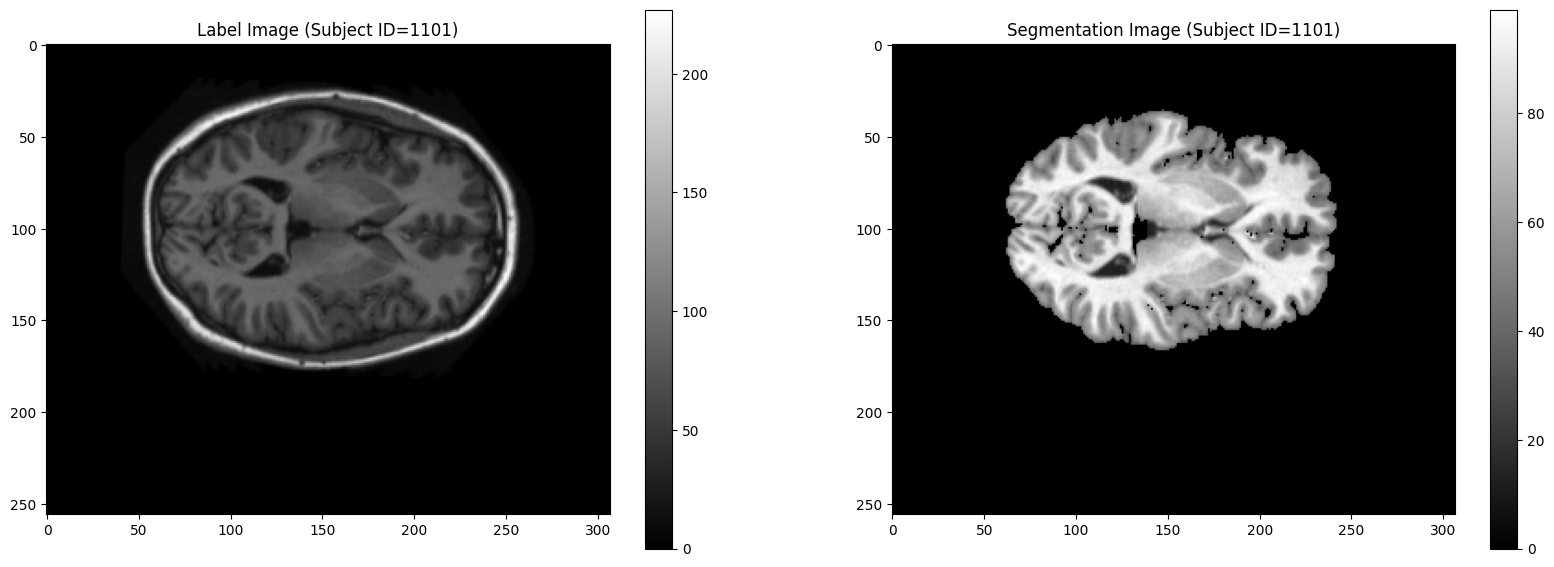

In [8]:
# perform skull stripping
skull_stripped = skull_stripping(test_intensity_example, test_label_example)

# display both intensity volume before and after skull stripping
NM.show_label_seg_nifti(test_intensity_example, skull_stripped, subject_id, slice=128)

In [10]:
# import tissue model csv
# fix labelling indexes
# in the saving, make sure to save without a header
tissue_map_csv = 'atlas_outputs/tissue_model_probability_data.csv'

In [11]:
segmentation_tissue_model = segment_using_tissue_models(skull_stripped, tissue_map_csv)

CSF DICE:  0.5012454858586104
GM DICE:  0.8966286786936227
WM DICE:  0.887851689399675


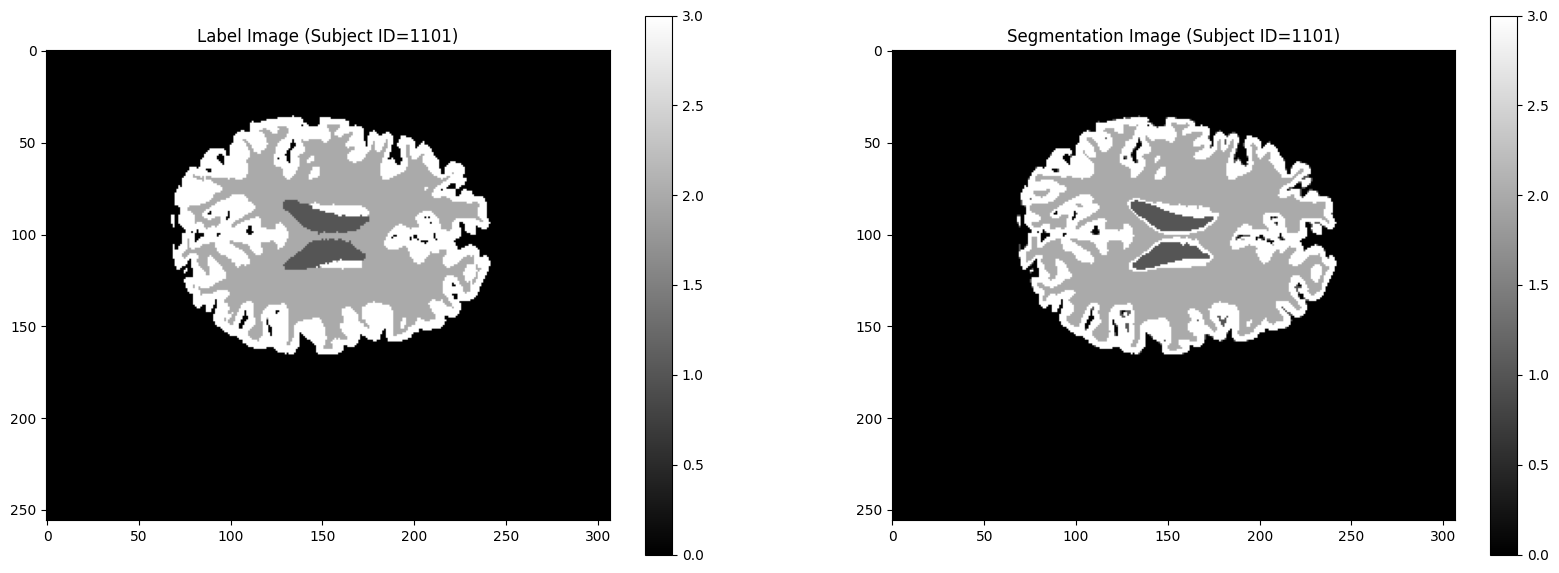

In [12]:
segmentation_tissue_model_bg  = segmentation_tissue_model == 0
segmentation_tissue_model_csf = segmentation_tissue_model == 1
segmentation_tissue_model_wm  = segmentation_tissue_model == 2
segmentation_tissue_model_gm  = segmentation_tissue_model == 3

labels_nifti_CSF              = test_label_example == 1
labels_nifti_WM               = test_label_example == 2
labels_nifti_GM               = test_label_example == 3

dice_csf    = EVAL.calc_dice_coefficient(labels_nifti_CSF, segmentation_tissue_model_csf)
dice_wm     = EVAL.calc_dice_coefficient(labels_nifti_WM, segmentation_tissue_model_wm)
dice_gm     = EVAL.calc_dice_coefficient(labels_nifti_GM, segmentation_tissue_model_gm)

print("CSF DICE: ", dice_csf)
print("GM DICE: ", dice_gm)
print("WM DICE: ", dice_wm)

# display both intensity volume before and after skull stripping
NM.show_label_seg_nifti(test_label_example, segmentation_tissue_model, subject_id, slice=148)

### (1.2) Label propagation: segmentation using just position information

To segment using the atlases, we need to register the test images and perform label propagation using the a reference frame. The reference frame for this task will be the averaged intensity atlas.

In [12]:
# register with float64 data volume
averaged_intensity_atlas_path = 'atlas_outputs/mean_intensity.nii.gz'
reg_params = '-p "Par0010affine.txt" -p "Par0010bspline.txt"'

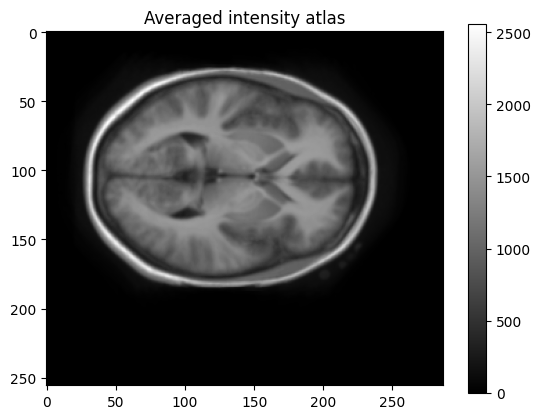

In [13]:
averaged_intensity_atlas, _ = NM.load_nifti(averaged_intensity_atlas_path)

NM.show_nifti(averaged_intensity_atlas, title="Averaged intensity atlas", slice=128)

**Run the next two cells only when you need to register and perform label propagation**

In [14]:
test_volumes

['test-set/testing-images\\1003.nii.gz',
 'test-set/testing-images\\1004.nii.gz',
 'test-set/testing-images\\1005.nii.gz',
 'test-set/testing-images\\1018.nii.gz',
 'test-set/testing-images\\1019.nii.gz',
 'test-set/testing-images\\1023.nii.gz',
 'test-set/testing-images\\1024.nii.gz',
 'test-set/testing-images\\1025.nii.gz',
 'test-set/testing-images\\1038.nii.gz',
 'test-set/testing-images\\1039.nii.gz',
 'test-set/testing-images\\1101.nii.gz',
 'test-set/testing-images\\1104.nii.gz',
 'test-set/testing-images\\1107.nii.gz',
 'test-set/testing-images\\1110.nii.gz',
 'test-set/testing-images\\1113.nii.gz',
 'test-set/testing-images\\1116.nii.gz',
 'test-set/testing-images\\1119.nii.gz',
 'test-set/testing-images\\1122.nii.gz',
 'test-set/testing-images\\1125.nii.gz',
 'test-set/testing-images\\1128.nii.gz']

In [55]:
# for test_volume, test_label in zip(test_volumes, test_labels):
#     image_id = test_volume.replace('\\', '/').split("/")[-1].split(".")[0]

#     # register an example test volume to the averaged intensity atlas
#     register_elastix(
#         fixed_path = averaged_intensity_atlas_path, 
#         moving_path = test_volume, 
#         reg_params = reg_params,
#         create_dir_callback = create_directory_if_not_exists,
#         excute_cmd_callback = excute_cmd)

#     # perform label propagation
#     label_propagation_transformix(
#         fixed_path = averaged_intensity_atlas_path, 
#         moving_path = test_volume, 
#         input_label = test_label,
#         transform_path = f'output/images/output_mean_intensity/{image_id}/TransformParameters.1.txt',
#         replace_text_in_file_callback = replace_text_in_file,
#         create_dir_callback = create_directory_if_not_exists,
#         excute_cmd_callback = excute_cmd)

Text replaced in output/images/output_mean_intensity/1003/TransformParameters.1.txt and saved.
Text replaced in output/images/output_mean_intensity/1004/TransformParameters.1.txt and saved.
Text replaced in output/images/output_mean_intensity/1005/TransformParameters.1.txt and saved.
Text replaced in output/images/output_mean_intensity/1018/TransformParameters.1.txt and saved.
Command failed with an error: elastix -f "atlas_outputs/mean_intensity.nii.gz" -m "test-set/testing-images\1019.nii.gz" -p "Par0010affine.txt" -p "Par0010bspline.txt" -out "output/images/output_mean_intensity/1019"

File not found: output/images/output_mean_intensity/1019/TransformParameters.1.txt
Command failed with an error: transformix -in "test-set/testing-labels\1019_3C.nii.gz" -tp "output/images/output_mean_intensity/1019/TransformParameters.1.txt"  -out "output/labels/output_mean_intensity/1019"

Text replaced in output/images/output_mean_intensity/1023/TransformParameters.1.txt and saved.
Text replaced in

In [15]:
atlas_csf_dir = 'atlas_outputs/mean_csf.nii.gz'
atlas_wm_dir  = 'atlas_outputs/mean_wm.nii.gz'
atlas_gm_dir  = 'atlas_outputs/mean_gm.nii.gz'

for test_volume, test_label in tqdm(zip(test_volumes, test_labels)):
    image_id = test_volume.replace('\\', '/').split("/")[-1].split(".")[0]

    # register an example test volume to the averaged intensity atlas
    register_elastix(
        fixed_path = test_volume, 
        moving_path = averaged_intensity_atlas_path, 
        reg_params = reg_params,
        create_dir_callback = create_directory_if_not_exists,
        excute_cmd_callback = excute_cmd)

    # perform label propagation to csf atlas
    label_propagation_transformix(
        fixed_path = test_volume, 
        moving_path = atlas_csf_dir, 
        input_label = atlas_csf_dir,
        transform_path = f'output/images/output_{image_id}/mean_intensity/TransformParameters.1.txt',
        replace_text_in_file_callback = replace_text_in_file,
        create_dir_callback = create_directory_if_not_exists,
        excute_cmd_callback = excute_cmd)

    # perform label propagation to csf atlas
    label_propagation_transformix(
        fixed_path = test_volume, 
        moving_path = atlas_wm_dir, 
        input_label = atlas_wm_dir,
        transform_path = f'output/images/output_{image_id}/mean_intensity/TransformParameters.1.txt',
        replace_text_in_file_callback = replace_text_in_file,
        create_dir_callback = create_directory_if_not_exists,
        excute_cmd_callback = excute_cmd)

    # perform label propagation to csf atlas
    label_propagation_transformix(
        fixed_path = test_volume, 
        moving_path = atlas_gm_dir, 
        input_label = atlas_gm_dir,
        transform_path = f'output/images/output_{image_id}/mean_intensity/TransformParameters.1.txt',
        replace_text_in_file_callback = replace_text_in_file,
        create_dir_callback = create_directory_if_not_exists,
        excute_cmd_callback = excute_cmd)
    

20it [57:45, 173.29s/it]


**Registratiton failed to the intensity atlas for: 1019, 1101**

After registering to the atlas reference space and performing label propagation, now we can perform segmentation using position information from the atlases.

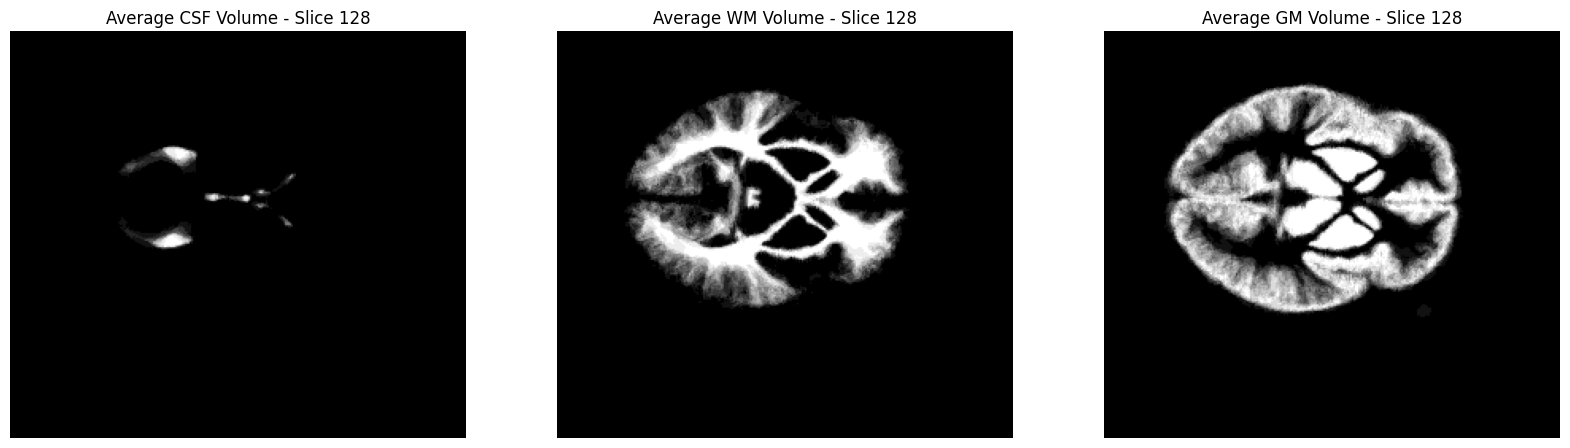

In [15]:
# load the three atlases for the three tissues
atlas_csf, _ = NM.load_nifti('atlas_outputs/mean_csf.nii.gz')
atlas_wm, _  = NM.load_nifti('atlas_outputs/mean_wm.nii.gz')
atlas_gm, _  = NM.load_nifti('atlas_outputs/mean_gm.nii.gz')

NM.show_mean_volumes(atlas_csf, atlas_wm, atlas_gm, slices=[128])

In [16]:
concatenated_atlas = np.column_stack((atlas_csf.flatten(), atlas_wm.flatten(), atlas_gm.flatten()))
concatenated_atlas.shape

(18808832, 3)

In [24]:
# load the registered test volume
volumes_output_path = f'output/images/output_mean_intensity/'

registered_volumes = sorted(glob(os.path.join(volumes_output_path, '**', "result.1.nii"), recursive=True))

In [25]:
registered_volumes

['output/images/output_mean_intensity\\1003\\result.1.nii',
 'output/images/output_mean_intensity\\1004\\result.1.nii',
 'output/images/output_mean_intensity\\1005\\result.1.nii',
 'output/images/output_mean_intensity\\1018\\result.1.nii',
 'output/images/output_mean_intensity\\1023\\result.1.nii',
 'output/images/output_mean_intensity\\1024\\result.1.nii',
 'output/images/output_mean_intensity\\1025\\result.1.nii',
 'output/images/output_mean_intensity\\1038\\result.1.nii',
 'output/images/output_mean_intensity\\1039\\result.1.nii',
 'output/images/output_mean_intensity\\1104\\result.1.nii',
 'output/images/output_mean_intensity\\1107\\result.1.nii',
 'output/images/output_mean_intensity\\1110\\result.1.nii',
 'output/images/output_mean_intensity\\1113\\result.1.nii',
 'output/images/output_mean_intensity\\1116\\result.1.nii',
 'output/images/output_mean_intensity\\1119\\result.1.nii',
 'output/images/output_mean_intensity\\1122\\result.1.nii',
 'output/images/output_mean_intensity\\1

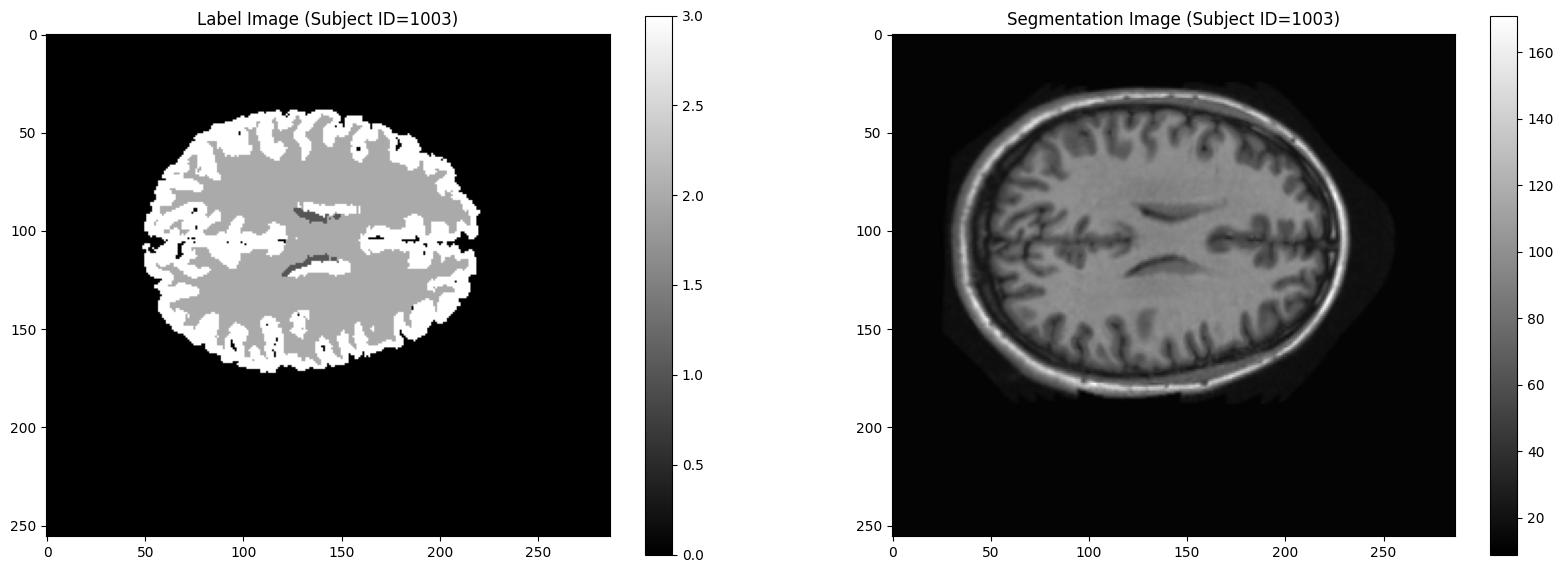

In [26]:
# take a single example to create the function
registered_volume_test_path = 'output/images/output_mean_intensity\\1003\\result.1.nii'
registered_volume_test, _ = NM.load_nifti(registered_volume_test_path)

registered_volume_test    = NM.min_max_normalization(registered_volume_test, 255).astype('uint8')   

registered_label_test_path = 'output/labels/output_mean_intensity\\1003\\result.nii'
registered_label_test, _ = NM.load_nifti(registered_label_test_path)

NM.show_label_seg_nifti(registered_label_test, registered_volume_test, 1003, slice=148)

In [27]:
# note that the shape matches the registered image, thus we can perform the segmentation!
registered_volume_test.flatten().shape 

(18808832,)

In [28]:
# before we segment the test, we perform skull stripping on it
registered_volume_test_ss = skull_stripping(registered_volume_test, registered_label_test)

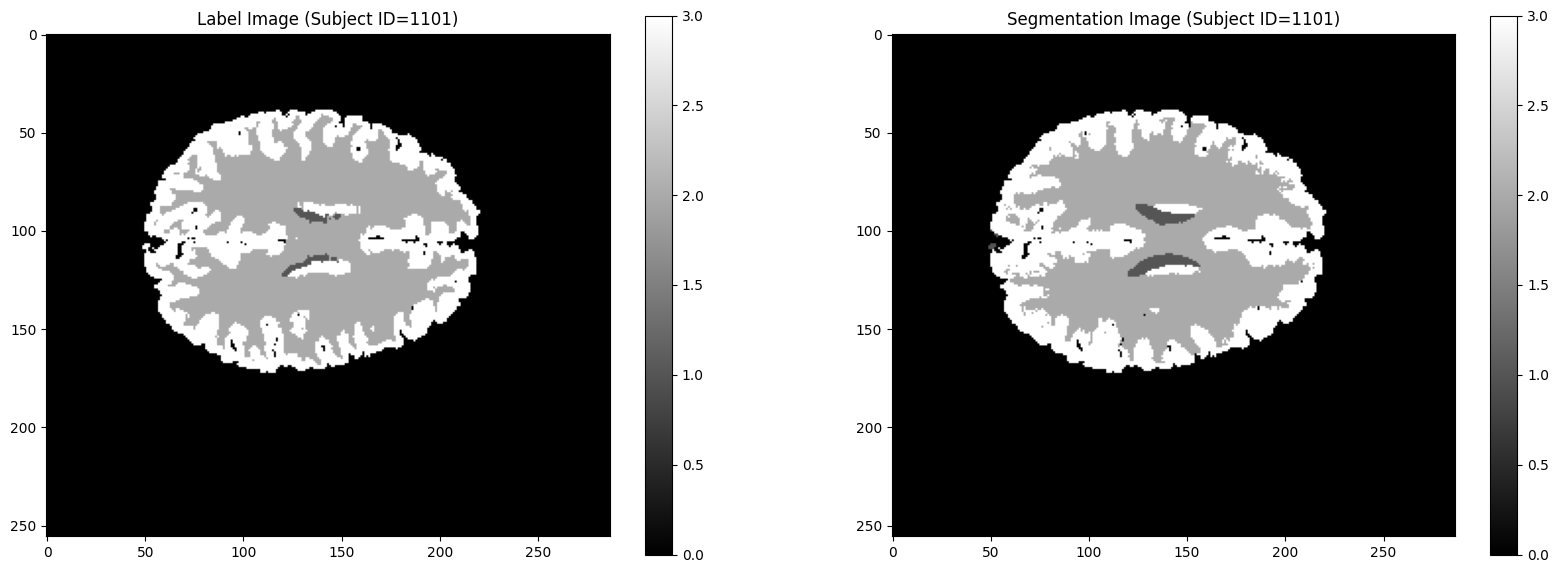

In [29]:
segmented_image = segment_using_tissue_atlas(registered_volume_test_ss, atlas_csf, atlas_wm, atlas_gm)

# NM.show_nifti(segmented_image, title="Segmented volume (Atlas)", slice=137)
# display both intensity volume before and after skull stripping
NM.show_label_seg_nifti(registered_label_test, segmented_image, subject_id, slice=148)

### (1.3) Tissue models & label propagation: multiplying both results: segmentation using intensity & position information

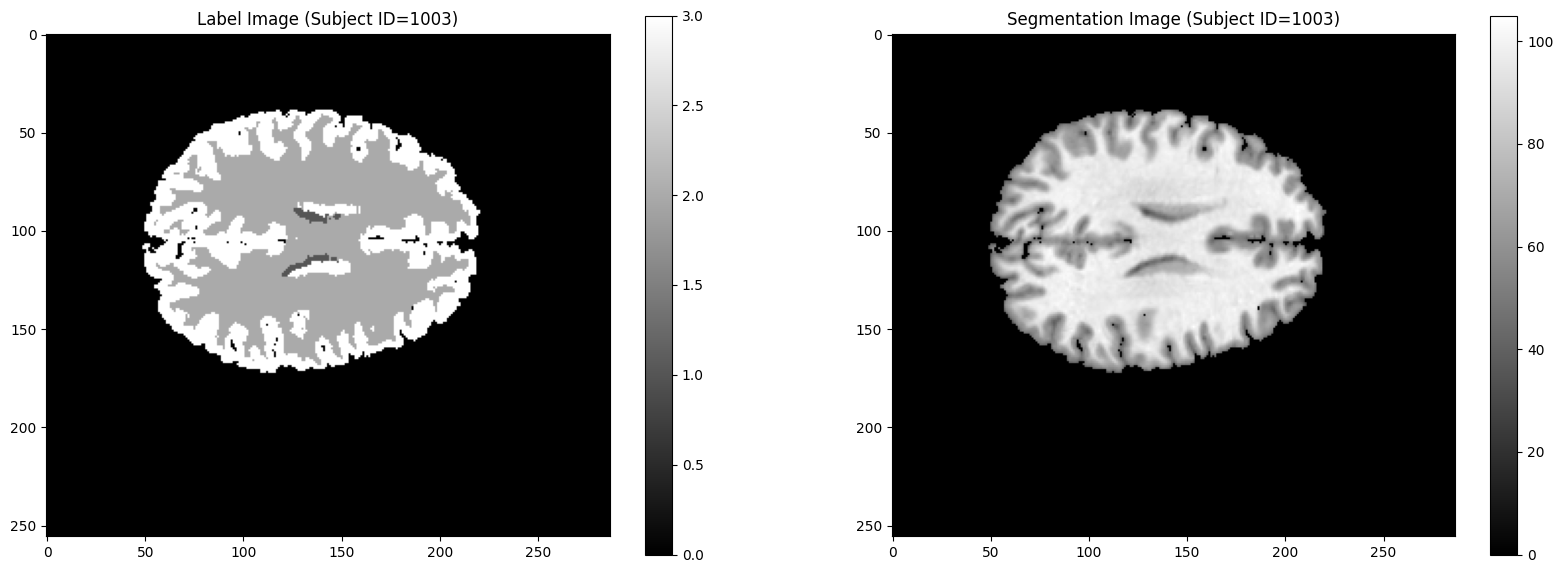

In [27]:
# performing this task on a single test volume
registered_volume_test_path = 'output/images/output_mean_intensity\\1003\\result.1.nii'
registered_volume_test, _ = NM.load_nifti(registered_volume_test_path)

registered_label_test_path = 'output/labels/output_mean_intensity\\1003\\result.nii'
registered_label_test, _ = NM.load_nifti(registered_label_test_path)

registered_volume_test    = NM.min_max_normalization(registered_volume_test, 255).astype('uint8')   
registered_volume_test    = skull_stripping(registered_volume_test, registered_label_test)

NM.show_label_seg_nifti(registered_label_test, registered_volume_test, 1003, slice=148)

In [28]:
# load the three atlases for the three tissues
atlas_csf, _ = NM.load_nifti('atlas_outputs/mean_csf.nii.gz')
atlas_wm, _  = NM.load_nifti('atlas_outputs/mean_wm.nii.gz')
atlas_gm, _  = NM.load_nifti('atlas_outputs/mean_gm.nii.gz')

In [29]:
# taking into account as well the intensity information
tissue_map_csv = 'atlas_outputs/tissue_model_probability_data.csv'

CSF DICE:  0.7377228082936269
GM DICE:  0.8941675060973182
WM DICE:  0.8691932759443267


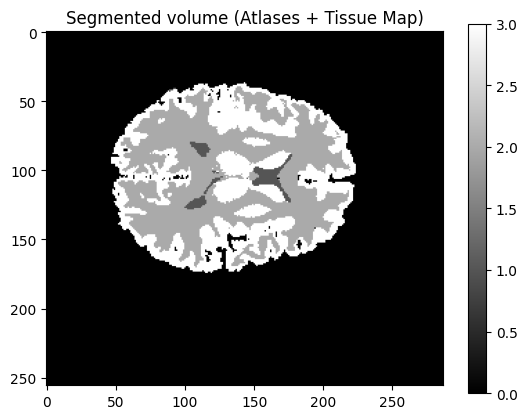

In [30]:
segmented_image = segment_using_tissue_models_and_atlas(
    registered_volume_test,
    tissue_map_csv,
    atlas_csf, 
    atlas_wm, 
    atlas_gm
)

segmented_image_bg  = segmented_image == 0
segmented_image_csf = segmented_image == 1
segmented_image_wm  = segmented_image == 2
segmented_image_gm  = segmented_image == 3

labels_nifti_CSF              = registered_label_test == 1
labels_nifti_WM               = registered_label_test == 2
labels_nifti_GM               = registered_label_test == 3

dice_csf    = EVAL.calc_dice_coefficient(labels_nifti_CSF, segmented_image_csf)
dice_wm     = EVAL.calc_dice_coefficient(labels_nifti_WM, segmented_image_wm)
dice_gm     = EVAL.calc_dice_coefficient(labels_nifti_GM, segmented_image_gm)

print("CSF DICE: ", dice_csf)
print("GM DICE: ", dice_gm)
print("WM DICE: ", dice_wm)

NM.show_nifti(segmented_image, title="Segmented volume (Atlases + Tissue Map)", slice=137)

## 4. Segmentation by EM from previous session. We will refine using just intensity information an initial segmentation obtained in different ways

### (2.1) Using k-Means initialisation (algorithm from past session): segmentation using intensity information

### (2.2) Using tissue models initialisation (1.1): segmentation using intensity information

In [63]:
tissue_map_csv = 'atlas_outputs/tissue_model_probability_data.csv'

subject_vol   = 'test-set/testing-images\\1101.nii.gz'
subject_label = 'test-set/testing-labels\\1101_3C.nii.gz'

subject_id = subject_vol.split('\\')[-1].split('.')[0]

test_intensity_example, _  = NM.load_nifti(subject_vol)
test_intensity_example     = NM.min_max_normalization(test_intensity_example, 255).astype('uint8')   

test_label_example, _      = NM.load_nifti(subject_label)

In [64]:
test_intensity_example.shape

(256, 307, 256)

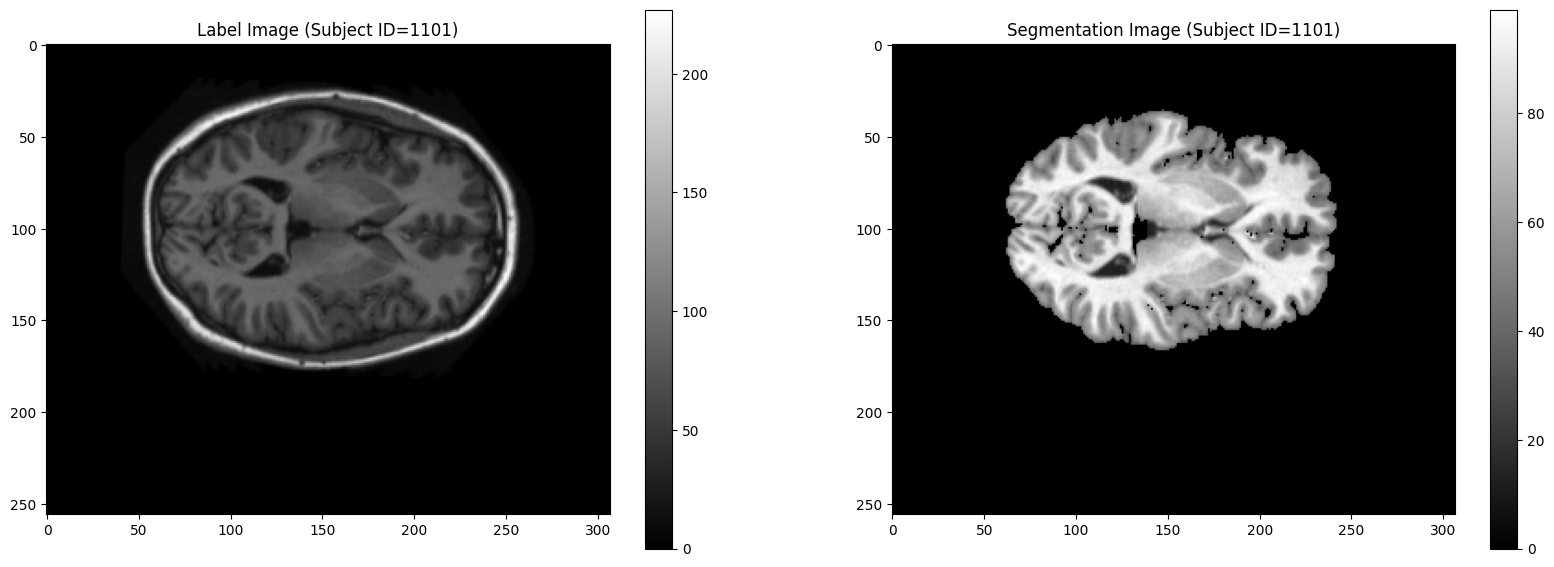

In [22]:
# perform skull stripping
skull_stripped = skull_stripping(test_intensity_example, test_label_example)

# display both intensity volume before and after skull stripping
NM.show_label_seg_nifti(test_intensity_example, skull_stripped, subject_id, slice=128)

In [72]:
print(skull_stripped.shape)
segmentation_tissue_model = segment_using_tissue_models(skull_stripped, tissue_map_csv)
print(segmentation_tissue_model.shape)

(256, 307, 256)
(256, 307, 256)


In [73]:
# flattened_seg = segmentation_tissue_model.flatten()
# print(len(flattened_seg))
# print(len(flattened_seg[flattened_seg==0]))
# print(len(flattened_seg[flattened_seg==1]))
# print(len(flattened_seg[flattened_seg==2]))
# print(len(flattened_seg[flattened_seg==3])) #GM has the most

In [74]:
labels = segmentation_tissue_model.flatten() # new labels

# we have to substract 1 as inside the function `segmentation_tissue_model`, we add 1 to the segmentation argmax predictions
# we also have to remove the 0 background 
cluster_labels = labels[labels!=0] - 1
cluster_labels.shape

(1450561,)

In [77]:
np.unique(cluster_labels)

array([0, 1, 2])

In [57]:
alpha_k        = np.array([np.sum([cluster_labels == i]) / len(cluster_labels) for i in range(3)]) # ratio for each cluster
print(alpha_k)
print(np.sum(alpha_k))

[0.03887393 0.43327719 0.52784888]
1.0


In [71]:
[i for i in range(1,4)]

[1, 2, 3]

In [95]:
skull_stripped.flatten()

array([0, 0, 0, ..., 0, 0, 0])

In [88]:
# np.ones(shape=(3,2))
clusters_masks = [labels == k for k in range(1, 4)]

# Calculate the mean for each cluster
cluster_means = np.array([np.mean(skull_stripped.flatten()[cluster_mask]) for cluster_mask in clusters_masks])

cluster_means_final = cluster_means[:, np.newaxis]

In [96]:
clusters_masks

[array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False])]

In [89]:
print(cluster_means)
print(cluster_means.shape)

print(cluster_means_final)
print(cluster_means_final.shape)

[29.67662133 82.79989499 53.38696996]
(3,)
[[29.67662133]
 [82.79989499]
 [53.38696996]]
(3, 1)


CSF DICE:  0.5012454858586104
GM DICE:  0.8966286786936227
WM DICE:  0.887851689399675


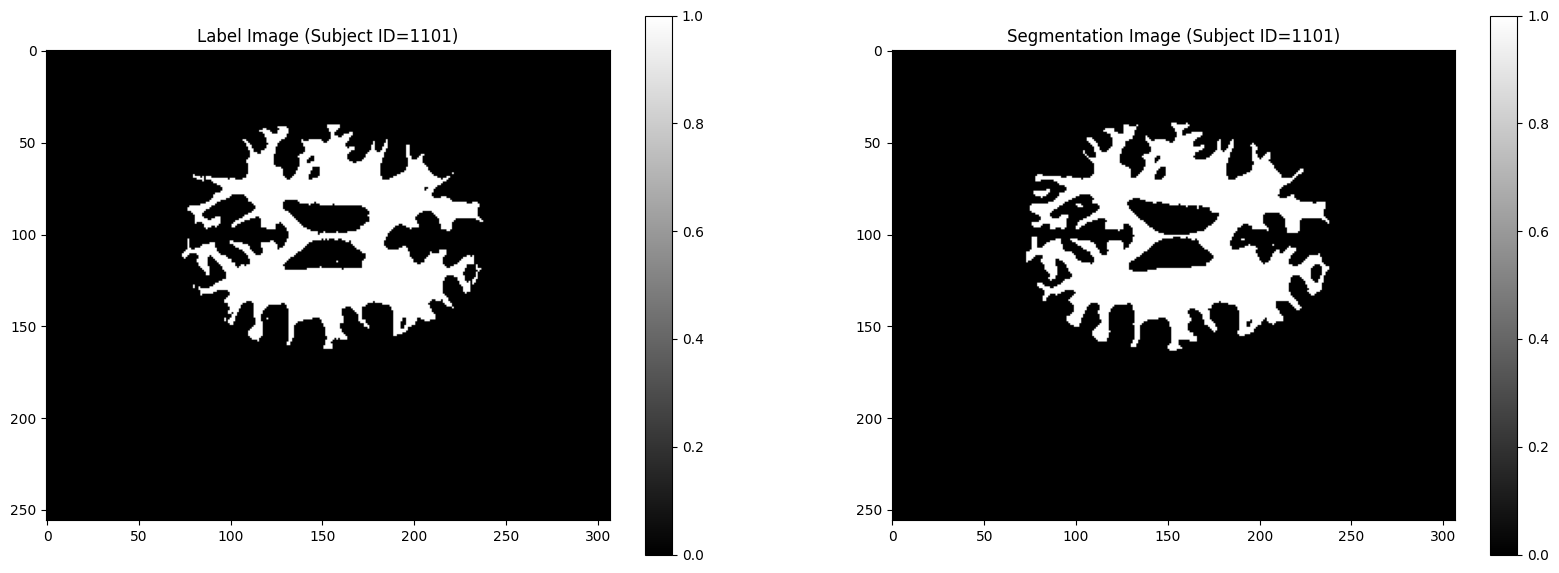

In [30]:
# segmentation_tissue_model_bg  = segmentation_tissue_model == 0
# segmentation_tissue_model_csf = segmentation_tissue_model == 1
# segmentation_tissue_model_wm  = segmentation_tissue_model == 2
# segmentation_tissue_model_gm  = segmentation_tissue_model == 3

# labels_nifti_CSF              = test_label_example == 1
# labels_nifti_WM               = test_label_example == 2
# labels_nifti_GM               = test_label_example == 3

# dice_csf    = EVAL.calc_dice_coefficient(labels_nifti_CSF, segmentation_tissue_model_csf)
# dice_wm     = EVAL.calc_dice_coefficient(labels_nifti_WM, segmentation_tissue_model_wm)
# dice_gm     = EVAL.calc_dice_coefficient(labels_nifti_GM, segmentation_tissue_model_gm)

# print("CSF DICE: ", dice_csf)
# print("GM DICE: ", dice_gm)
# print("WM DICE: ", dice_wm)

# # display both intensity volume before and after skull stripping
# NM.show_label_seg_nifti(labels_nifti_WM, segmentation_tissue_model_wm, subject_id, slice=148)